In [0]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.despine()

%matplotlib notebook

## Colab

In [0]:
from google.colab import drive
drive.mount('gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at gdrive


In [0]:
!git clone https://github.com/ne3x7/torchdiffeq.git

Cloning into 'torchdiffeq'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 187 (delta 0), reused 2 (delta 0), pack-reused 178
Receiving objects: 100% (187/187), 704.90 KiB | 1.83 MiB/s, done.
Resolving deltas: 100% (77/77), done.


In [0]:
from torchdiffeq.torchdiffeq import odeint_adjoint

## Neural ODE

In [0]:
def get_initial_values(P0, Q0, V0, angle0, theta0, Sn=2220, Vn=400, fn=60, Sb=100, Vb=400):
    """
    Initializes generator state vector `x` and network terminal variables vector `V`
    in machine base from given power flow values in system base and angle in radians.
    """
    
    # unpack parameters guess
    ws = 1
    KD = 0
    ra, x1d, xd, xq, H, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = theta0
    
    # define transforms
    
    # vf_MB = vf * Vb / Vn
    wb = 2 * np.pi * fn
    S_SBtoMB = Sb / Sn
    V_MBtoSB = Vn / Vb
    I_MBtoSB = Sn * Vb / (Sb * Vn)
    Z_MBtoSB = Sb * Vn ** 2 / (Sn * Vb ** 2)
    
    # initialize stator quantitites
    
    p0 = P0 / Sb
    q0 = Q0 / Sb
    Vt0 = V0 * np.exp(1j * angle0)
    S0 = p0 - 1j * q0
    I0 = S0 / Vt0.conjugate()
    vr0 = Vt0.real
    vi0 = Vt0.imag
    ir0 = -I0.real
    ii0 = -I0.imag
    
    # initialize DQ-quantities
    
    w0 = 1
    delta0 = np.angle(Vt0 + (ra + 1j * xq) * Z_MBtoSB * I0)
    
    Vdq0 = Vt0 * (1 / V_MBtoSB) * np.exp(1j * (-delta0 + np.pi/2))
    Idq0 = I0 * (1 / I_MBtoSB) * np.exp(1j * (-delta0 + np.pi/2))
    
    vd0 = Vdq0.real
    vq0 = Vdq0.imag
    id0 = Idq0.real
    iq0 = Idq0.imag
    
    # initialize order 3
    
    e1q0 = vq0 + ra * iq0 + x1d * id0
    
    # initialize AVR
    
    v = np.abs(Vt0)
    vref = v
    vs0 = 0
    vm0 = v
    vf0 = (e1q0 + (xd - x1d) * id0) * V_MBtoSB
    vr0 = K0 * (1 - Tavr1 / Tavr2) * (vref + vs0 - vm0)
    
    # initialize PSS
    
    v20 = 0
    
    # constants
    
    pm = (vq0 + ra * iq0) * iq0 + (vd0 + ra * id0) * id0
    vsmin, vsmax = -0.2, 0.2
    vfmin, vfmax = -6.4, 7
    
    # pack values
    
    x = np.array([delta0, w0, v20, vs0, vm0, vr0, vf0, e1q0])
    V = np.array([vd0, vq0, id0, iq0])
    c = np.array([pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, vs0, wb, KD])
    
    return x, V, c, (p0, q0)

In [0]:
class RHSTrue(nn.Module):
    def __init__(self, v, c, t):
        super(RHSTrue, self).__init__()
        
        self.theta = torch.from_numpy(np.array([0.003, 0.3, 1.81, 1.76, 3.5, 8.,
                                                10., 10., 0.05, 0.02, 0.015, 1.,
                                                1., 0.0001, 200]))
        self.c = c
        self.vt = lambda x: np.interp(x, t, v[:, 0])
        self.phi = lambda x: np.interp(x, t, v[:, 1])
        
    def forward(self, t, x):
        v = torch.tensor([self.vt(t), self.phi(t)])

        vd = v[0] * torch.sin(x[0] - v[1])
        vq = v[0] * torch.cos(x[0] - v[1])

        id = (self.theta[3] * x[7] - self.theta[3] * vq - self.theta[0] * vd) / (self.theta[1] * self.theta[3] + self.theta[0] ** 2)
        iq = (self.theta[0] * x[7] - self.theta[0] * vq + self.theta[1] * vd) / (self.theta[1] * self.theta[3] + self.theta[0] ** 2)

        p = 22.2 * (vd * id + vq * iq)
        q = 22.2 * (vq * id - vd * iq)
        
        pe = (vq + self.theta[0] * iq) * iq + (vd + self.theta[0] * id) * id

        return torch.stack([
            self.c[8] * (x[1] - 1),
            (self.c[0] - pe) / (2 * self.theta[4]),
            self.theta[6] * (self.c[0] - pe) / (2 * self.theta[4]) - x[2] / self.theta[7],
            (self.theta[8] * (self.theta[6] * (self.c[0] - pe)
                              / (2 * self.theta[4]) - x[2]
                              / self.theta[7]) + x[2] - x[3]) / self.theta[9],
            (v[0] - x[4]) / self.theta[10],
            (self.theta[14] * (1 - self.theta[11] / self.theta[12]) * (self.c[5] + x[3] - x[4]) - x[5]) / self.theta[12],
            ((x[5] + self.theta[14] * self.theta[11] * (self.c[5] + x[3] - x[4])
              / self.theta[12] + self.c[6]) * (1 + self.c[7] * (v[0] / x[4] - 1)) - x[6]) / self.theta[13],
            (- x[7] - (self.theta[2] - self.theta[1]) * id + x[6]) / self.theta[5]
        ])

In [0]:
class RHS(nn.Module):
    def __init__(self, v, c, t):
        super(RHS, self).__init__()
        
        self.theta = nn.Parameter(torch.rand(15))
        self.s = torch.from_numpy(np.array([0.01, 1., 10., 10., 10., 10.,
                                            10., 10., 0.1, 0.1, 0.1, 1.,
                                            1., 0.001, 1000]))
        self.c = c
        self.vt = lambda x: np.interp(x.detach().numpy(), t.detach().numpy(), v[:, 0])
        self.phi = lambda x: np.interp(x.detach().numpy(), t.detach().numpy(), v[:, 1])
        
    def forward(self, t, x):
        v = torch.tensor([self.vt(t), self.phi(t)])

        vd = v[0] * torch.sin(x[0] - v[1])
        vq = v[0] * torch.cos(x[0] - v[1])

        id = (self.s[3] * self.theta[3] * x[7] - self.s[3] * self.theta[3] * vq - self.s[0] * self.theta[0] * vd) / (self.s[1] * self.theta[1] * self.s[3] * self.theta[3] + (self.s[0] * self.theta[0]) ** 2)
        iq = (self.s[0] * self.theta[0] * x[7] - self.s[0] * self.theta[0] * vq + self.s[1] * self.theta[1] * vd) / (self.s[1] * self.theta[1] * self.s[3] * self.theta[3] + (self.s[0] * self.theta[0]) ** 2)
        p = 22.2 * (vd * id + vq * iq)
        q = 22.2 * (vq * id - vd * iq)
        
        pe = (vq + self.s[0] * self.theta[0] * iq) * iq + (vd + self.s[0] * self.theta[0] * id) * id

        return torch.stack([
            self.c[8] * (x[1] - 1),
            (self.c[0] - pe) / (2 * self.s[4] * self.theta[4]),
            self.s[6] * self.theta[6] * (self.c[0] - pe) / (2 * self.s[4] * self.theta[4]) - x[2] / (self.s[7] * self.theta[7]),
            (self.s[8] * self.theta[8] * (self.s[6] * self.theta[6] * (self.c[0] - pe)
                              / (2 * self.s[4] * self.theta[4]) - x[2]
                              / (self.s[7] * self.theta[7])) + x[2] - x[3]) / (self.s[9] * self.theta[9]),
            (v[0] - x[4]) / (self.s[10] * self.theta[10]),
            (self.s[14] * self.theta[14] * (1 - self.s[11] * self.theta[11] / (self.s[12] * self.theta[12])) * (self.c[5] + x[3] - x[4]) - x[5]) / (self.s[12] * self.theta[12]),
            ((x[5] + self.s[14] * self.theta[14] * self.s[11] * self.theta[11] * (self.c[5] + x[3] - x[4])
              / (self.s[12] * self.theta[12]) + self.c[6]) * (1 + self.c[7] * (v[0] / x[4] - 1)) - x[6]) / (self.s[13] * self.theta[13]),
            (- x[7] - (self.s[2] * self.theta[2] - self.s[1] * self.theta[1]) * id + x[6]) / (self.s[5] * self.theta[5])
        ])

In [0]:
data_size = 60001
batch_time = 5000
batch_size = 1
t = torch.linspace(0, 6, steps=data_size)
# df = pd.read_csv('./exportedVariables.csv')
df = pd.read_csv('./exportedVariables2.csv')
df = df.drop_duplicates('time')
df = df.drop(['time'], axis=1)
# df.columns = ['p', 'q', 'v', 'phi']
df.columns = ['v', 'vm', 'vr', 'p', 'q', 'phi', 'delta',
              'e1q', 'id', 'iq', 'ii', 'ir', 'vi', 'vrr',
              'vd', 'vf', 'vq', 'w', 'vs']
df = df.drop(['ii', 'ir', 'vi', 'vrr', 'vd', 'vq', 'id', 'iq'], axis=1)
df.phi = df.phi * np.pi / 180
v = df[['v', 'phi']].values
x0, v0, c, (p0, q0) = get_initial_values(P0=1997.9999999936396,
                                         Q0=967.9249699065775,
                                         V0=1.0,
                                         angle0=0.494677176989154,
                                         theta0=np.array([0.003, 0.3, 1.81, 1.76, 3.5, 8.,
                                                          10., 10., 0.05, 0.02, 0.015, 1.,
                                                          1., 0.0001, 200]))
with torch.no_grad():
    rhs_true = RHSTrue(v, c, t)
    true_y = odeint(rhs_true, torch.from_numpy(x0), t, method='euler')

In [0]:
deltas = true_y[:, 0]
e1qs = true_y[:, -1]
pqs = []
for delta, e1q, vt, phi in zip(deltas, e1qs, df.v, df.phi):
    vd = vt * np.sin(delta - phi)
    vq = vt * np.cos(delta - phi)
    
    id = (1.76 * e1q - 1.76 * vq - 0.003 * vd) / (0.3 * 1.76 + 0.003 ** 2)
    iq = (0.003 * e1q - 0.003 * vq + 0.3 * vd) / (0.3 * 1.76 + 0.003 ** 2)
    
    p = 22.2 * (vd * id + vq * iq)
    q = 22.2 * (vq * id - vd * iq)
    pqs.append([p, q])
pqs = np.array(pqs)

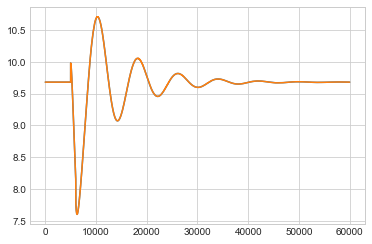

In [0]:
plt.plot(df.q)
plt.plot(pqs[:, 1])

In [0]:
def get_batch_size_one():
    s = np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), replace=False)
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[s:s+batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[s:s+batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

In [0]:
rhs = RHS(v, c, t)
rhs.double()
optimizer = optim.RMSprop(rhs.parameters())
for iter_n in range(100):
    theta_prev = rhs.theta.clone()
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch_size_one()
    pred_y = odeint(rhs, batch_y0, batch_t, method='euler')
    loss = (pred_y - batch_y).pow(2).sum()
    loss.backward()
    optimizer.step()
    for param in rhs.parameters():
        param.data.clamp_(min=1e-1, max=1)
    reference = (rhs.theta - torch.from_numpy(np.array([0.003, 0.3, 1.81, 1.76, 3.5, 8.,
                                                        10., 10., 0.05, 0.02, 0.015, 1.,
                                                        1., 0.0001, 200])) / rhs.s).pow(2).sum().sqrt().item()
    # dist = (rhs.theta - theta_prev).pow(2).sum().sqrt().item()
    print('[%04d]\tloss\t%e\tdistance to solution\t%e' % (iter_n, loss.item(), reference))

[0000]	loss	4.201730e+02	distance to solution	1.481507e+00
[0001]	loss	6.687639e+03	distance to solution	1.531861e+00
[0002]	loss	8.195462e+02	distance to solution	1.578573e+00
[0003]	loss	2.103704e+04	distance to solution	1.592682e+00
[0004]	loss	2.387337e+03	distance to solution	1.656268e+00
[0005]	loss	3.107268e+02	distance to solution	1.664373e+00
[0006]	loss	7.596270e+01	distance to solution	1.666671e+00
[0007]	loss	1.736171e+02	distance to solution	1.671954e+00
[0008]	loss	1.450553e+02	distance to solution	1.676510e+00
[0009]	loss	2.683221e+02	distance to solution	1.674523e+00
[0010]	loss	1.384540e+03	distance to solution	1.695968e+00
[0011]	loss	2.400408e+03	distance to solution	1.682781e+00
[0012]	loss	1.442574e+03	distance to solution	1.728786e+00
[0013]	loss	1.925383e+02	distance to solution	1.733962e+00
[0014]	loss	1.316206e+02	distance to solution	1.736749e+00
[0015]	loss	8.316121e+01	distance to solution	1.738998e+00
[0016]	loss	1.660724e+04	distance to solution	1.732532e+

In [0]:
for iter_n in range(1000):
    theta_prev = rhs.theta.clone()
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch_size_one()
    pred_y = odeint(rhs, batch_y0, batch_t, method='euler')
    loss = (pred_y - batch_y).pow(2).sum()
    loss.backward()
    optimizer.step()
    for param in rhs.parameters():
        param.data.clamp_(min=1e-1, max=1)
    reference = (rhs.theta - torch.from_numpy(np.array([0.003, 0.3, 1.81, 1.76, 3.5, 8.,
                                                        10., 10., 0.05, 0.02, 0.015, 1.,
                                                        1., 0.0001, 200])) / rhs.s).pow(2).sum().sqrt().item()
    # dist = (rhs.theta - theta_prev).pow(2).sum().sqrt().item()
    print('[%04d]\tloss\t%e\tdistance to solution\t%e' % (iter_n, loss.item(), reference))

[0000]	loss	1.302833e+01	distance to solution	1.419892e+00
[0001]	loss	3.280174e+00	distance to solution	1.419795e+00
[0002]	loss	6.010175e-01	distance to solution	1.419908e+00
[0003]	loss	4.871973e-01	distance to solution	1.419946e+00
[0004]	loss	1.897405e-01	distance to solution	1.419905e+00
[0005]	loss	9.240494e-02	distance to solution	1.419936e+00
[0006]	loss	1.326901e+01	distance to solution	1.419559e+00
[0007]	loss	7.072579e+00	distance to solution	1.419092e+00
[0008]	loss	6.368595e+01	distance to solution	1.418007e+00
[0009]	loss	4.535810e+01	distance to solution	1.419548e+00
[0010]	loss	1.078237e+01	distance to solution	1.418968e+00
[0011]	loss	4.615867e+00	distance to solution	1.419085e+00
[0012]	loss	1.166033e+00	distance to solution	1.419004e+00
[0013]	loss	4.378177e+02	distance to solution	1.419800e+00
[0014]	loss	4.897506e+02	distance to solution	1.416390e+00
[0015]	loss	2.764019e+02	distance to solution	1.420586e+00
[0016]	loss	9.476992e+01	distance to solution	1.418852e+

[0139]	loss	4.895202e+00	distance to solution	1.365692e+00
[0140]	loss	1.222147e+01	distance to solution	1.365518e+00
[0141]	loss	1.204142e+01	distance to solution	1.364902e+00
[0142]	loss	1.668057e+01	distance to solution	1.364948e+00
[0143]	loss	5.626315e+01	distance to solution	1.362379e+00
[0144]	loss	9.139004e+02	distance to solution	1.361411e+00
[0145]	loss	8.161087e+02	distance to solution	1.356901e+00
[0146]	loss	6.491148e+02	distance to solution	1.364371e+00
[0147]	loss	2.356111e+02	distance to solution	1.361929e+00
[0148]	loss	1.012652e+02	distance to solution	1.364314e+00
[0149]	loss	1.859775e+02	distance to solution	1.360212e+00
[0150]	loss	1.307006e+02	distance to solution	1.360824e+00
[0151]	loss	8.839679e+01	distance to solution	1.359783e+00
[0152]	loss	1.064690e+01	distance to solution	1.359416e+00
[0153]	loss	3.290539e+00	distance to solution	1.359796e+00
[0154]	loss	1.759861e+02	distance to solution	1.356891e+00
[0155]	loss	1.057153e+02	distance to solution	1.353953e+

[0278]	loss	6.734295e+01	distance to solution	1.282630e+00
[0279]	loss	1.844073e+02	distance to solution	1.282759e+00
[0280]	loss	5.340751e+01	distance to solution	1.284003e+00
[0281]	loss	1.212299e+01	distance to solution	1.283179e+00
[0282]	loss	3.659374e+00	distance to solution	1.283641e+00
[0283]	loss	3.125022e+02	distance to solution	1.282282e+00
[0284]	loss	6.734647e+01	distance to solution	1.282166e+00
[0285]	loss	1.645888e+01	distance to solution	1.281802e+00
[0286]	loss	4.279872e+00	distance to solution	1.282100e+00
[0287]	loss	1.409346e+01	distance to solution	1.281759e+00
[0288]	loss	7.603629e+01	distance to solution	1.278877e+00
[0289]	loss	4.479878e+01	distance to solution	1.280487e+00
[0290]	loss	8.848275e+00	distance to solution	1.279809e+00
[0291]	loss	2.021995e+00	distance to solution	1.280151e+00
[0292]	loss	5.515753e+02	distance to solution	1.278460e+00
[0293]	loss	4.683314e+02	distance to solution	1.286444e+00
[0294]	loss	1.376717e+02	distance to solution	1.283905e+

[0417]	loss	8.613859e+01	distance to solution	1.259435e+00
[0418]	loss	2.086441e+01	distance to solution	1.260923e+00
[0419]	loss	6.447813e+01	distance to solution	1.258459e+00
[0420]	loss	3.819658e+01	distance to solution	1.260125e+00
[0421]	loss	1.125427e+01	distance to solution	1.259241e+00
[0422]	loss	3.307390e+00	distance to solution	1.259714e+00
[0423]	loss	1.208451e+02	distance to solution	1.253284e+00
[0424]	loss	9.124656e+01	distance to solution	1.256579e+00
[0425]	loss	1.600398e+01	distance to solution	1.255761e+00
[0426]	loss	1.196620e+00	distance to solution	1.256088e+00
[0427]	loss	4.311918e+02	distance to solution	1.251643e+00
[0428]	loss	1.887891e+02	distance to solution	1.257184e+00
[0429]	loss	1.827495e+02	distance to solution	1.251714e+00
[0430]	loss	2.425313e+02	distance to solution	1.258067e+00
[0431]	loss	1.486656e+02	distance to solution	1.255542e+00
[0432]	loss	9.547729e+01	distance to solution	1.260549e+00
[0433]	loss	3.967595e+01	distance to solution	1.259101e+

[0556]	loss	1.042823e+03	distance to solution	1.218393e+00
[0557]	loss	5.182938e+01	distance to solution	1.218460e+00
[0558]	loss	3.155986e+00	distance to solution	1.217874e+00
[0559]	loss	1.694925e+01	distance to solution	1.218315e+00
[0560]	loss	1.192783e+03	distance to solution	1.218844e+00
[0561]	loss	7.479336e+02	distance to solution	1.239141e+00
[0562]	loss	1.261646e+02	distance to solution	1.236918e+00
[0563]	loss	7.953776e+00	distance to solution	1.237583e+00
[0564]	loss	1.245772e+02	distance to solution	1.234826e+00
[0565]	loss	1.728540e+03	distance to solution	1.238897e+00
[0566]	loss	2.020533e+03	distance to solution	1.228256e+00
[0567]	loss	1.260103e+03	distance to solution	1.248732e+00
[0568]	loss	2.118767e+02	distance to solution	1.251711e+00
[0569]	loss	1.156847e+02	distance to solution	1.252604e+00
[0570]	loss	3.899914e+00	distance to solution	1.252616e+00
[0571]	loss	9.985323e-01	distance to solution	1.252783e+00
[0572]	loss	7.090165e-01	distance to solution	1.252675e+

[0695]	loss	1.520948e+01	distance to solution	1.165826e+00
[0696]	loss	9.712498e+00	distance to solution	1.164694e+00
[0697]	loss	2.517106e+01	distance to solution	1.164568e+00
[0698]	loss	3.236877e+00	distance to solution	1.164088e+00
[0699]	loss	2.687076e+00	distance to solution	1.164723e+00
[0700]	loss	3.898682e+01	distance to solution	1.163535e+00
[0701]	loss	9.961920e+02	distance to solution	1.154263e+00
[0702]	loss	2.041225e+02	distance to solution	1.161407e+00
[0703]	loss	8.785655e+02	distance to solution	1.152326e+00
[0704]	loss	2.016322e+03	distance to solution	1.178336e+00
[0705]	loss	1.239463e+03	distance to solution	1.174714e+00
[0706]	loss	4.124783e+02	distance to solution	1.167435e+00
[0707]	loss	2.330940e+02	distance to solution	1.169121e+00
[0708]	loss	1.980354e+03	distance to solution	1.159873e+00
[0709]	loss	3.843575e+02	distance to solution	1.162270e+00
[0710]	loss	5.040887e+02	distance to solution	1.151762e+00
[0711]	loss	4.996971e+02	distance to solution	1.162013e+

[0834]	loss	2.036812e+01	distance to solution	1.166423e+00
[0835]	loss	2.013180e+01	distance to solution	1.167965e+00
[0836]	loss	5.906627e+00	distance to solution	1.167723e+00
[0837]	loss	3.165608e+02	distance to solution	1.161710e+00
[0838]	loss	1.544891e+02	distance to solution	1.158282e+00
[0839]	loss	7.090258e+01	distance to solution	1.160486e+00
[0840]	loss	1.794139e+01	distance to solution	1.159315e+00
[0841]	loss	4.618189e+01	distance to solution	1.150636e+00
[0842]	loss	9.181637e+01	distance to solution	1.149889e+00
[0843]	loss	6.063713e+01	distance to solution	1.148673e+00
[0844]	loss	3.901037e+01	distance to solution	1.151174e+00
[0845]	loss	5.775005e+01	distance to solution	1.148852e+00
[0846]	loss	3.528516e+01	distance to solution	1.147153e+00
[0847]	loss	1.461873e+02	distance to solution	1.144841e+00
[0848]	loss	4.442781e+01	distance to solution	1.146349e+00
[0849]	loss	6.685865e+00	distance to solution	1.146285e+00
[0850]	loss	6.751830e-01	distance to solution	1.146599e+

[0973]	loss	1.289108e+01	distance to solution	1.176540e+00
[0974]	loss	4.173566e+01	distance to solution	1.175924e+00
[0975]	loss	1.963249e+01	distance to solution	1.179278e+00
[0976]	loss	4.604200e+02	distance to solution	1.181334e+00
[0977]	loss	4.540319e+02	distance to solution	1.195741e+00
[0978]	loss	3.944657e-01	distance to solution	1.195772e+00
[0979]	loss	1.186694e+01	distance to solution	1.195717e+00
[0980]	loss	6.394129e+00	distance to solution	1.195955e+00
[0981]	loss	5.549379e-01	distance to solution	1.195742e+00
[0982]	loss	1.249328e+00	distance to solution	1.195888e+00
[0983]	loss	3.421903e+00	distance to solution	1.195562e+00
[0984]	loss	1.602392e+00	distance to solution	1.195910e+00
[0985]	loss	1.184913e+03	distance to solution	1.202819e+00
[0986]	loss	1.153752e+03	distance to solution	1.201829e+00
[0987]	loss	4.732737e+02	distance to solution	1.213119e+00
[0988]	loss	7.677938e+01	distance to solution	1.210176e+00
[0989]	loss	4.079136e+00	distance to solution	1.210322e+

In [0]:
with torch.no_grad():
    pred_y = odeint(rhs, torch.from_numpy(x0), t, method='euler')

deltas = pred_y[:, 0]
e1qs = pred_y[:, -1]
pqs = []
for delta, e1q, vt, phi in zip(deltas, e1qs, df.v, df.phi):
    vd = vt * np.sin(delta - phi)
    vq = vt * np.cos(delta - phi)
    
    id = (1.76 * e1q - 1.76 * vq - 0.003 * vd) / (0.3 * 1.76 + 0.003 ** 2)
    iq = (0.003 * e1q - 0.003 * vq + 0.3 * vd) / (0.3 * 1.76 + 0.003 ** 2)
    
    p = 22.2 * (vd * id + vq * iq)
    q = 22.2 * (vq * id - vd * iq)
    pqs.append([p, q])
pqs = np.array(pqs)

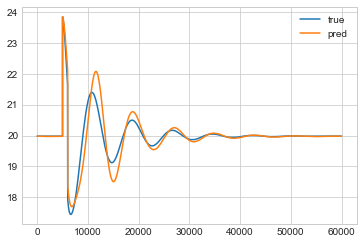

In [0]:
plt.plot(df.p, label='true')
plt.plot(pqs[:, 0], label='pred')
plt.legend()

In [0]:
import dill as pickle

In [0]:
with open('rhs_optimizer.pkl', 'wb') as f:
    pickle.dump((rhs, optimizer), f)

## Modified

In [0]:
from modules.torchdiffeq.torchdiffeq import odeint_adjoint

%load_ext autoreload
%autoreload 2

In [0]:
def get_initial_values(P0, Q0, V0, angle0, theta0, Sn=2220, Vn=400, fn=60, Sb=100, Vb=400):
    """
    Initializes generator state vector `x` and network terminal variables vector `V`
    in machine base from given power flow values in system base and angle in radians.
    """
    
    # unpack parameters guess
    ws = 1
    KD = 0
    ra, x1d, xd, xq, H, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = theta0
    
    # define transforms
    
    # vf_MB = vf * Vb / Vn
    wb = 2 * np.pi * fn
    S_SBtoMB = Sb / Sn
    V_MBtoSB = Vn / Vb
    I_MBtoSB = Sn * Vb / (Sb * Vn)
    Z_MBtoSB = Sb * Vn ** 2 / (Sn * Vb ** 2)
    
    # initialize stator quantitites
    
    p0 = P0 / Sb
    q0 = Q0 / Sb
    Vt0 = V0 * np.exp(1j * angle0)
    S0 = p0 - 1j * q0
    I0 = S0 / Vt0.conjugate()
    vr0 = Vt0.real
    vi0 = Vt0.imag
    ir0 = -I0.real
    ii0 = -I0.imag
    
    # initialize DQ-quantities
    
    w0 = 1
    delta0 = np.angle(Vt0 + (ra + 1j * xq) * Z_MBtoSB * I0)
    
    Vdq0 = Vt0 * (1 / V_MBtoSB) * np.exp(1j * (-delta0 + np.pi/2))
    Idq0 = I0 * (1 / I_MBtoSB) * np.exp(1j * (-delta0 + np.pi/2))
    
    vd0 = Vdq0.real
    vq0 = Vdq0.imag
    id0 = Idq0.real
    iq0 = Idq0.imag
    
    # initialize order 3
    
    e1q0 = vq0 + ra * iq0 + x1d * id0
    
    # initialize AVR
    
    v = np.abs(Vt0)
    vref = v
    vs0 = 0
    vm0 = v
    vf0 = (e1q0 + (xd - x1d) * id0) * V_MBtoSB
    vr0 = K0 * (1 - Tavr1 / Tavr2) * (vref + vs0 - vm0)
    
    # initialize PSS
    
    v20 = 0
    
    # constants
    
    pm = (vq0 + ra * iq0) * iq0 + (vd0 + ra * id0) * id0
    vsmin, vsmax = -0.2, 0.2
    vfmin, vfmax = -6.4, 7
    
    # pack values
    
    x = np.array([delta0, w0, v20, vs0, vm0, vr0, vf0, e1q0])
    V = np.array([vd0, vq0, id0, iq0])
    c = np.array([pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, vs0, wb, KD])
    
    return x, V, c, (p0, q0)

In [0]:
class RHSTrue(nn.Module):
    def __init__(self, c):
        super(RHSTrue, self).__init__()
        
        self.theta = torch.from_numpy(np.array([0.003, 0.3, 1.81, 1.76, 3.5, 8.,
                                                10., 10., 0.05, 0.02, 0.015, 1.,
                                                1., 0.0001, 200]))
        self.c = c
        
    def forward(self, t, x, v):
        vd = v[:, 0] * torch.sin(x[:, 0] - v[:, 1])
        vq = v[:, 0] * torch.cos(x[:, 0] - v[:, 1])

        id = (self.theta[3] * x[:, 7] - self.theta[3] * vq - self.theta[0] * vd) / (self.theta[1] * self.theta[3] + self.theta[0] ** 2)
        iq = (self.theta[0] * x[:, 7] - self.theta[0] * vq + self.theta[1] * vd) / (self.theta[1] * self.theta[3] + self.theta[0] ** 2)

        p = 22.2 * (vd * id + vq * iq)
        q = 22.2 * (vq * id - vd * iq)
        
        pe = (vq + self.theta[0] * iq) * iq + (vd + self.theta[0] * id) * id

        return torch.stack([
            self.c[8] * (x[:, 1] - 1),
            (self.c[0] - pe) / (2 * self.theta[4]),
            self.theta[6] * (self.c[0] - pe) / (2 * self.theta[4]) - x[:, 2] / self.theta[7],
            (self.theta[8] * (self.theta[6] * (self.c[0] - pe)
                              / (2 * self.theta[4]) - x[:, 2]
                              / self.theta[7]) + x[:, 2] - x[:, 3]) / self.theta[9],
            (v[:, 0] - x[:, 4]) / self.theta[10],
            (self.theta[14] * (1 - self.theta[11] / self.theta[12]) * (self.c[5] + x[:, 3] - x[:, 4]) - x[:, 5]) / self.theta[12],
            ((x[:, 5] + self.theta[14] * self.theta[11] * (self.c[5] + x[:, 3] - x[:, 4])
              / self.theta[12] + self.c[6]) * (1 + self.c[7] * (v[:, 0] / x[:, 4] - 1)) - x[:, 6]) / self.theta[13],
            (- x[:, 7] - (self.theta[2] - self.theta[1]) * id + x[:, 6]) / self.theta[5]
        ], dim=1)

In [0]:
class RHS(nn.Module):
    def __init__(self, c):
        super(RHS, self).__init__()
        
        self.theta = nn.Parameter(torch.rand(15))
        self.s = torch.from_numpy(np.array([0.01, 1., 10., 10., 10., 10.,
                                            10., 10., 0.1, 0.1, 0.1, 1.,
                                            1., 0.001, 1000]))
        self.c = c
        
    def forward(self, t, x, v):
        vd = v[:, 0] * torch.sin(x[:, 0] - v[:, 1])
        vq = v[:, 0] * torch.cos(x[:, 0] - v[:, 1])

        id = (self.s[3] * self.theta[3] * x[:, 7] - self.s[3] * self.theta[3] * vq - self.s[0] * self.theta[0] * vd) / (self.s[1] * self.theta[1] * self.s[3] * self.theta[3] + (self.s[0] * self.theta[0]) ** 2)
        iq = (self.s[0] * self.theta[0] * x[:, 7] - self.s[0] * self.theta[0] * vq + self.s[1] * self.theta[1] * vd) / (self.s[1] * self.theta[1] * self.s[3] * self.theta[3] + (self.s[0] * self.theta[0]) ** 2)
        p = 22.2 * (vd * id + vq * iq)
        q = 22.2 * (vq * id - vd * iq)
        
        pe = (vq + self.s[0] * self.theta[0] * iq) * iq + (vd + self.s[0] * self.theta[0] * id) * id

        return torch.stack([
            self.c[8] * (x[:, 1] - 1),
            (self.c[0] - pe) / (2 * self.s[4] * self.theta[4]),
            self.s[6] * self.theta[6] * (self.c[0] - pe) / (2 * self.s[4] * self.theta[4]) - x[:, 2] / (self.s[7] * self.theta[7]),
            (self.s[8] * self.theta[8] * (self.s[6] * self.theta[6] * (self.c[0] - pe)
                              / (2 * self.s[4] * self.theta[4]) - x[:, 2]
                              / (self.s[7] * self.theta[7])) + x[:, 2] - x[:, 3]) / (self.s[9] * self.theta[9]),
            (v[:, 0] - x[:, 4]) / (self.s[10] * self.theta[10]),
            (self.s[14] * self.theta[14] * (1 - self.s[11] * self.theta[11] / (self.s[12] * self.theta[12])) * (self.c[5] + x[:, 3] - x[:, 4]) - x[:, 5]) / (self.s[12] * self.theta[12]),
            ((x[:, 5] + self.s[14] * self.theta[14] * self.s[11] * self.theta[11] * (self.c[5] + x[:, 3] - x[:, 4])
              / (self.s[12] * self.theta[12]) + self.c[6]) * (1 + self.c[7] * (v[:, 0] / x[:, 4] - 1)) - x[:, 6]) / (self.s[13] * self.theta[13]),
            (- x[:, 7] - (self.s[2] * self.theta[2] - self.s[1] * self.theta[1]) * id + x[:, 6]) / (self.s[5] * self.theta[5])
        ], dim=1)

In [0]:
data_size = 60001
batch_time = 5000
batch_size = 1
t = torch.linspace(0, 6, steps=data_size)
# df = pd.read_csv('./exportedVariables.csv')
df = pd.read_csv('./exportedVariables2.csv')
df = df.drop_duplicates('time')
df = df.drop(['time'], axis=1)
# df.columns = ['p', 'q', 'v', 'phi']
df.columns = ['v', 'vm', 'vr', 'p', 'q', 'phi', 'delta',
              'e1q', 'id', 'iq', 'ii', 'ir', 'vi', 'vrr',
              'vd', 'vf', 'vq', 'w', 'vs']
df = df.drop(['ii', 'ir', 'vi', 'vrr', 'vd', 'vq', 'id', 'iq'], axis=1)
df.phi = df.phi * np.pi / 180
v = df[['v', 'phi']].values
x0, v0, c, (p0, q0) = get_initial_values(P0=1997.9999999936396,
                                         Q0=967.9249699065775,
                                         V0=1.0,
                                         angle0=0.494677176989154,
                                         theta0=np.array([0.003, 0.3, 1.81, 1.76, 3.5, 8.,
                                                          10., 10., 0.05, 0.02, 0.015, 1.,
                                                          1., 0.0001, 200]))
with torch.no_grad():
    rhs_true = RHSTrue(c)
    true_y = odeint_adjoint(rhs_true, torch.from_numpy(x0[None]), torch.from_numpy(v[:, None, :]), t, method='euler').squeeze(1)

In [0]:
deltas = true_y[:, 0]
e1qs = true_y[:, -1]
pqs = []
for delta, e1q, vt, phi in zip(deltas, e1qs, df.v, df.phi):
    vd = vt * np.sin(delta - phi)
    vq = vt * np.cos(delta - phi)
    
    id = (1.76 * e1q - 1.76 * vq - 0.003 * vd) / (0.3 * 1.76 + 0.003 ** 2)
    iq = (0.003 * e1q - 0.003 * vq + 0.3 * vd) / (0.3 * 1.76 + 0.003 ** 2)
    
    p = 22.2 * (vd * id + vq * iq)
    q = 22.2 * (vq * id - vd * iq)
    pqs.append([p, q])
pqs = np.array(pqs)

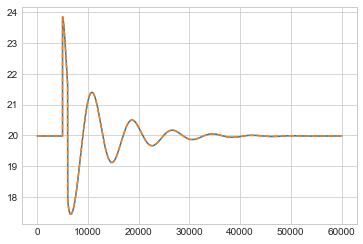

In [0]:
plt.plot(df.p)
plt.plot(pqs[:, 0], '--')

In [0]:
exog_y = torch.from_numpy(v)

In [0]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    batch_y_exog = torch.stack([exog_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y, batch_y_exog

In [0]:
# rhs = RHS(c)
# rhs.double()
# optimizer = optim.RMSprop(rhs.parameters())
for iter_n in range(1000):
    theta_prev = rhs.theta.clone()
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y, batch_y_exog = get_batch()
    pred_y = odeint_adjoint(rhs, batch_y0, batch_y_exog, batch_t, method='euler')
    loss = (pred_y - batch_y).pow(2).sum()
    loss.backward()
    optimizer.step()
    for param in rhs.parameters():
        param.data.clamp_(min=1e-1, max=1)
    reference = (rhs.theta - torch.from_numpy(np.array([0.003, 0.3, 1.81, 1.76, 3.5, 8.,
                                                        10., 10., 0.05, 0.02, 0.015, 1.,
                                                        1., 0.0001, 200])) / rhs.s).pow(2).sum().sqrt().item()
    # dist = (rhs.theta - theta_prev).pow(2).sum().sqrt().item()
    print('[%04d]\tloss\t%e\tdistance to solution\t%e' % (iter_n, loss.item(), reference))

[0000]	loss	1.173243e+02	distance to solution	1.190581e+00
[0001]	loss	2.117506e+01	distance to solution	1.189950e+00
[0002]	loss	5.484082e+00	distance to solution	1.190138e+00
[0003]	loss	5.048112e+00	distance to solution	1.190054e+00
[0004]	loss	2.496500e+00	distance to solution	1.189760e+00
[0005]	loss	3.825489e+00	distance to solution	1.190077e+00
[0006]	loss	7.033792e+00	distance to solution	1.189541e+00
[0007]	loss	2.207016e+02	distance to solution	1.179917e+00
[0008]	loss	9.608656e+01	distance to solution	1.179336e+00
[0009]	loss	3.187703e+02	distance to solution	1.168480e+00
[0010]	loss	2.225013e+01	distance to solution	1.169630e+00
[0011]	loss	1.827879e+02	distance to solution	1.162513e+00
[0012]	loss	1.703222e+02	distance to solution	1.165811e+00
[0013]	loss	9.208435e+01	distance to solution	1.163014e+00
[0014]	loss	6.070243e+01	distance to solution	1.165632e+00
[0015]	loss	3.914749e+01	distance to solution	1.164152e+00
[0016]	loss	2.857272e+01	distance to solution	1.165840e+

[0139]	loss	6.584457e+01	distance to solution	1.097829e+00
[0140]	loss	4.708423e+01	distance to solution	1.097579e+00
[0141]	loss	2.149006e+02	distance to solution	1.094332e+00
[0142]	loss	5.411157e+01	distance to solution	1.091319e+00
[0143]	loss	1.109024e+02	distance to solution	1.094962e+00
[0144]	loss	7.797549e+01	distance to solution	1.091405e+00
[0145]	loss	2.427125e+01	distance to solution	1.091933e+00
[0146]	loss	1.062905e+01	distance to solution	1.090954e+00
[0147]	loss	1.090226e+01	distance to solution	1.091900e+00
[0148]	loss	3.046018e+01	distance to solution	1.088953e+00
[0149]	loss	3.166555e+02	distance to solution	1.086857e+00
[0150]	loss	3.540148e+02	distance to solution	1.083086e+00
[0151]	loss	2.540566e+02	distance to solution	1.088998e+00
[0152]	loss	7.313144e+02	distance to solution	1.070664e+00
[0153]	loss	1.498712e+02	distance to solution	1.070014e+00
[0154]	loss	1.554117e+02	distance to solution	1.071003e+00
[0155]	loss	2.909185e+02	distance to solution	1.076032e+

[0278]	loss	3.507490e+02	distance to solution	1.067302e+00
[0279]	loss	5.341289e+01	distance to solution	1.067669e+00
[0280]	loss	5.919886e+01	distance to solution	1.066104e+00
[0281]	loss	4.030930e+01	distance to solution	1.067822e+00
[0282]	loss	6.762167e+00	distance to solution	1.067453e+00
[0283]	loss	1.043165e+01	distance to solution	1.068599e+00
[0284]	loss	6.420974e+00	distance to solution	1.069206e+00
[0285]	loss	4.954526e+01	distance to solution	1.071421e+00
[0286]	loss	6.760804e+01	distance to solution	1.069900e+00
[0287]	loss	1.445796e+03	distance to solution	1.049618e+00
[0288]	loss	1.092841e+01	distance to solution	1.049536e+00
[0289]	loss	6.173846e-01	distance to solution	1.049396e+00
[0290]	loss	6.394244e-01	distance to solution	1.049517e+00
[0291]	loss	1.003750e+00	distance to solution	1.049252e+00
[0292]	loss	1.049775e+01	distance to solution	1.048465e+00
[0293]	loss	6.367986e+00	distance to solution	1.049431e+00
[0294]	loss	7.272111e+00	distance to solution	1.048158e+

[0417]	loss	4.962603e+00	distance to solution	1.004473e+00
[0418]	loss	1.077833e+01	distance to solution	1.005197e+00
[0419]	loss	4.502849e+02	distance to solution	1.011169e+00
[0420]	loss	2.005207e+03	distance to solution	9.835736e-01
[0421]	loss	2.643676e+03	distance to solution	1.021585e+00
[0422]	loss	6.313922e+01	distance to solution	1.020563e+00
[0423]	loss	2.818565e-01	distance to solution	1.020616e+00
[0424]	loss	1.005141e-01	distance to solution	1.020648e+00
[0425]	loss	2.719220e+00	distance to solution	1.020607e+00
[0426]	loss	5.992114e+01	distance to solution	1.019072e+00
[0427]	loss	3.167677e+01	distance to solution	1.020898e+00
[0428]	loss	3.153538e+00	distance to solution	1.021189e+00
[0429]	loss	4.749750e+02	distance to solution	1.029036e+00
[0430]	loss	2.485986e+02	distance to solution	1.021359e+00
[0431]	loss	2.323623e+01	distance to solution	1.021394e+00
[0432]	loss	9.635437e-01	distance to solution	1.021606e+00
[0433]	loss	8.441305e-02	distance to solution	1.021609e+

[0556]	loss	3.404538e-01	distance to solution	9.669402e-01
[0557]	loss	4.973805e+02	distance to solution	9.687328e-01
[0558]	loss	1.558960e+02	distance to solution	9.620266e-01
[0559]	loss	1.300621e+02	distance to solution	9.677230e-01
[0560]	loss	1.470291e+02	distance to solution	9.637918e-01
[0561]	loss	1.813416e+02	distance to solution	9.703525e-01
[0562]	loss	1.867111e+02	distance to solution	9.648348e-01
[0563]	loss	2.122279e+02	distance to solution	9.718803e-01
[0564]	loss	1.580213e+02	distance to solution	9.686142e-01
[0565]	loss	1.313860e+02	distance to solution	9.738145e-01
[0566]	loss	7.293961e+01	distance to solution	9.721868e-01
[0567]	loss	6.520436e+01	distance to solution	9.732770e-01
[0568]	loss	1.124710e+02	distance to solution	9.648964e-01
[0569]	loss	1.333454e+02	distance to solution	9.701877e-01
[0570]	loss	7.125517e+01	distance to solution	9.677370e-01
[0571]	loss	1.068714e+02	distance to solution	9.636253e-01
[0572]	loss	1.356289e+02	distance to solution	9.572839e-

[0695]	loss	2.899716e+01	distance to solution	9.256271e-01
[0696]	loss	2.443371e+01	distance to solution	9.242477e-01
[0697]	loss	1.453955e+01	distance to solution	9.249583e-01
[0698]	loss	5.612124e+00	distance to solution	9.242725e-01
[0699]	loss	1.165386e+00	distance to solution	9.246383e-01
[0700]	loss	1.152795e+02	distance to solution	9.235836e-01
[0701]	loss	5.784979e+00	distance to solution	9.227541e-01
[0702]	loss	1.073289e+01	distance to solution	9.228276e-01
[0703]	loss	2.429921e+00	distance to solution	9.232809e-01
[0704]	loss	2.111060e+00	distance to solution	9.230120e-01
[0705]	loss	1.784380e+00	distance to solution	9.226640e-01
[0706]	loss	1.092486e+00	distance to solution	9.225485e-01
[0707]	loss	5.992614e+00	distance to solution	9.227915e-01
[0708]	loss	4.139209e+00	distance to solution	9.222832e-01
[0709]	loss	6.192394e+00	distance to solution	9.210876e-01
[0710]	loss	8.331403e+00	distance to solution	9.221078e-01
[0711]	loss	6.858876e+00	distance to solution	9.212907e-

[0834]	loss	3.758648e+01	distance to solution	9.115635e-01
[0835]	loss	5.482556e+01	distance to solution	9.092665e-01
[0836]	loss	6.640216e+01	distance to solution	9.136020e-01
[0837]	loss	5.973874e+01	distance to solution	9.105161e-01
[0838]	loss	6.374837e+01	distance to solution	9.143219e-01
[0839]	loss	7.099676e+01	distance to solution	9.110810e-01
[0840]	loss	5.771549e+01	distance to solution	9.161516e-01
[0841]	loss	5.778431e+01	distance to solution	9.121224e-01
[0842]	loss	2.114420e+02	distance to solution	9.232557e-01
[0843]	loss	5.190854e+02	distance to solution	9.152568e-01
[0844]	loss	5.549757e+02	distance to solution	9.178041e-01
[0845]	loss	8.002199e+02	distance to solution	9.105451e-01
[0846]	loss	8.844577e+02	distance to solution	9.262335e-01
[0847]	loss	2.605163e+02	distance to solution	9.145824e-01
[0848]	loss	5.749448e+01	distance to solution	9.168339e-01
[0849]	loss	1.597602e+01	distance to solution	9.161359e-01
[0850]	loss	1.177127e+01	distance to solution	9.174342e-

[0973]	loss	3.868429e+02	distance to solution	9.954088e-01
[0974]	loss	3.674973e+02	distance to solution	9.917829e-01
[0975]	loss	2.400513e+01	distance to solution	9.917525e-01
[0976]	loss	1.042612e-01	distance to solution	9.917108e-01
[0977]	loss	3.047740e+01	distance to solution	9.877745e-01
[0978]	loss	5.102119e+01	distance to solution	9.904738e-01
[0979]	loss	1.809170e+01	distance to solution	9.892243e-01
[0980]	loss	9.732270e+00	distance to solution	9.902169e-01
[0981]	loss	2.301161e+02	distance to solution	9.816451e-01
[0982]	loss	2.293601e+02	distance to solution	9.841266e-01
[0983]	loss	2.165863e+01	distance to solution	9.821634e-01
[0984]	loss	4.889567e+01	distance to solution	9.804479e-01
[0985]	loss	2.306287e+02	distance to solution	9.764707e-01
[0986]	loss	1.339475e+01	distance to solution	9.758384e-01
[0987]	loss	7.129729e-01	distance to solution	9.758483e-01
[0988]	loss	3.961902e-02	distance to solution	9.758050e-01
[0989]	loss	3.138707e+00	distance to solution	9.759306e-

In [0]:
with torch.no_grad():
    pred_y = odeint_adjoint(rhs, torch.from_numpy(x0[None]), torch.from_numpy(v[:, None, :]), t, method='euler').squeeze(1)

deltas = pred_y[:, 0]
e1qs = pred_y[:, -1]
pqs = []
for delta, e1q, vt, phi in zip(deltas, e1qs, df.v, df.phi):
    vd = vt * np.sin(delta - phi)
    vq = vt * np.cos(delta - phi)
    
    id = (1.76 * e1q - 1.76 * vq - 0.003 * vd) / (0.3 * 1.76 + 0.003 ** 2)
    iq = (0.003 * e1q - 0.003 * vq + 0.3 * vd) / (0.3 * 1.76 + 0.003 ** 2)
    
    p = 22.2 * (vd * id + vq * iq)
    q = 22.2 * (vq * id - vd * iq)
    pqs.append([p, q])
pqs = np.array(pqs)

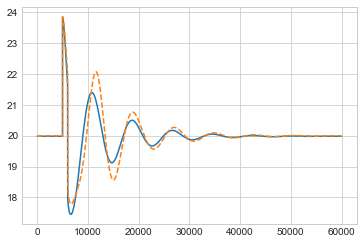

In [0]:
plt.plot(df.p)
plt.plot(pqs[:, 0], '--')

In [0]:
batch_time = 10000
for iter_n in range(500):
    theta_prev = rhs.theta.clone()
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y, batch_y_exog = get_batch()
    pred_y = odeint_adjoint(rhs, batch_y0, batch_y_exog, batch_t, method='euler')
    loss = (pred_y - batch_y).pow(2).sum()
    loss.backward()
    optimizer.step()
    for param in rhs.parameters():
        param.data.clamp_(min=1e-1, max=1)
    reference = (rhs.theta - torch.from_numpy(np.array([0.003, 0.3, 1.81, 1.76, 3.5, 8.,
                                                        10., 10., 0.05, 0.02, 0.015, 1.,
                                                        1., 0.0001, 200])) / rhs.s).pow(2).sum().sqrt().item()
    # dist = (rhs.theta - theta_prev).pow(2).sum().sqrt().item()
    print('[%04d]\tloss\t%e\tdistance to solution\t%e' % (iter_n, loss.item(), reference))

[0000]	loss	4.624683e+02	distance to solution	9.803678e-01
[0001]	loss	3.518761e+02	distance to solution	9.586814e-01
[0002]	loss	7.231462e+01	distance to solution	9.614479e-01
[0003]	loss	1.492304e+03	distance to solution	9.697583e-01
[0004]	loss	1.883998e+02	distance to solution	9.698385e-01
[0005]	loss	3.761284e+03	distance to solution	9.740205e-01
[0006]	loss	7.462555e+02	distance to solution	9.818591e-01
[0007]	loss	5.701252e+03	distance to solution	9.965842e-01
[0008]	loss	2.486402e+02	distance to solution	1.007447e+00
[0009]	loss	1.214001e+02	distance to solution	1.004895e+00
[0010]	loss	5.621646e+01	distance to solution	1.007807e+00
[0011]	loss	4.900477e+02	distance to solution	9.960341e-01
[0012]	loss	5.714523e+01	distance to solution	9.970973e-01
[0013]	loss	6.475661e+02	distance to solution	9.920699e-01
[0014]	loss	7.037100e+02	distance to solution	9.899156e-01
[0015]	loss	1.384187e+02	distance to solution	9.864959e-01
[0016]	loss	1.038422e+02	distance to solution	9.902576e-

[0139]	loss	8.016226e+01	distance to solution	9.011324e-01
[0140]	loss	4.074436e+00	distance to solution	9.003488e-01
[0141]	loss	8.591682e+02	distance to solution	8.931327e-01
[0142]	loss	1.081075e+02	distance to solution	8.899408e-01
[0143]	loss	9.759368e+00	distance to solution	8.911656e-01
[0144]	loss	2.786978e+02	distance to solution	8.895853e-01
[0145]	loss	1.198107e+02	distance to solution	8.948137e-01
[0146]	loss	6.409782e+01	distance to solution	8.931356e-01
[0147]	loss	1.918662e+01	distance to solution	8.951654e-01
[0148]	loss	7.791360e+00	distance to solution	8.945592e-01
[0149]	loss	1.424035e-01	distance to solution	8.946079e-01
[0150]	loss	3.247119e-02	distance to solution	8.946515e-01
[0151]	loss	7.133086e+01	distance to solution	8.956591e-01
[0152]	loss	5.522388e+01	distance to solution	8.929778e-01
[0153]	loss	1.837985e+01	distance to solution	8.948705e-01
[0154]	loss	2.993983e+01	distance to solution	8.935613e-01
[0155]	loss	1.200299e+03	distance to solution	8.985955e-

[0278]	loss	8.942693e+01	distance to solution	8.547675e-01
[0279]	loss	7.390042e+01	distance to solution	8.586644e-01
[0280]	loss	4.621549e+01	distance to solution	8.557868e-01
[0281]	loss	2.904294e+01	distance to solution	8.580692e-01
[0282]	loss	5.349186e+02	distance to solution	8.649389e-01
[0283]	loss	1.131893e+02	distance to solution	8.639003e-01
[0284]	loss	1.334268e+02	distance to solution	8.623949e-01
[0285]	loss	8.648400e+01	distance to solution	8.650155e-01
[0286]	loss	8.183035e+01	distance to solution	8.610825e-01
[0287]	loss	1.295418e+02	distance to solution	8.665621e-01
[0288]	loss	2.028429e+02	distance to solution	8.599104e-01
[0289]	loss	8.855485e+02	distance to solution	8.664877e-01
[0290]	loss	1.351037e+03	distance to solution	8.479972e-01
[0291]	loss	1.480929e+03	distance to solution	8.657639e-01
[0292]	loss	2.789088e+02	distance to solution	8.609140e-01
[0293]	loss	2.387438e+02	distance to solution	8.616246e-01
[0294]	loss	2.564503e+02	distance to solution	8.678953e-

[0417]	loss	3.283133e+02	distance to solution	8.801904e-01
[0418]	loss	9.344276e+01	distance to solution	8.843029e-01
[0419]	loss	2.425333e+02	distance to solution	8.810075e-01
[0420]	loss	8.516027e+00	distance to solution	8.808327e-01
[0421]	loss	1.273392e+00	distance to solution	8.807872e-01
[0422]	loss	1.195215e+02	distance to solution	8.757250e-01
[0423]	loss	3.879401e+02	distance to solution	8.805205e-01
[0424]	loss	2.143774e+01	distance to solution	8.780725e-01
[0425]	loss	1.529673e+03	distance to solution	8.780204e-01
[0426]	loss	8.507896e+01	distance to solution	8.777226e-01
[0427]	loss	1.172880e+01	distance to solution	8.771398e-01
[0428]	loss	2.432007e+01	distance to solution	8.774776e-01
[0429]	loss	3.815995e+00	distance to solution	8.769930e-01
[0430]	loss	1.986593e-02	distance to solution	8.769541e-01
[0431]	loss	4.791912e+03	distance to solution	8.976064e-01
[0432]	loss	5.376888e+03	distance to solution	8.802477e-01
[0433]	loss	2.271350e+03	distance to solution	9.022827e-

In [0]:
with torch.no_grad():
    pred_y = odeint_adjoint(rhs, torch.from_numpy(x0[None]), torch.from_numpy(v[:, None, :]), t, method='euler').squeeze(1)

deltas = pred_y[:, 0]
e1qs = pred_y[:, -1]
pqs = []
for delta, e1q, vt, phi in zip(deltas, e1qs, df.v, df.phi):
    vd = vt * np.sin(delta - phi)
    vq = vt * np.cos(delta - phi)
    
    id = (1.76 * e1q - 1.76 * vq - 0.003 * vd) / (0.3 * 1.76 + 0.003 ** 2)
    iq = (0.003 * e1q - 0.003 * vq + 0.3 * vd) / (0.3 * 1.76 + 0.003 ** 2)
    
    p = 22.2 * (vd * id + vq * iq)
    q = 22.2 * (vq * id - vd * iq)
    pqs.append([p, q])
pqs = np.array(pqs)

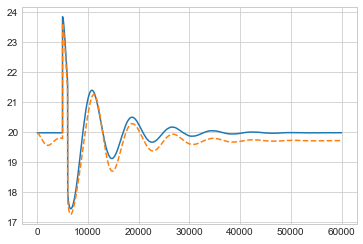

In [0]:
plt.plot(df.p)
plt.plot(pqs[:, 0], '--')

## Multi-file

In [0]:
class RHSTrue(nn.Module):
    def __init__(self, c):
        super(RHSTrue, self).__init__()
        
        self.theta = torch.from_numpy(np.array([0.003, 0.3, 1.81, 1.76, 3.5, 8.,
                                                10., 10., 0.05, 0.02, 0.015, 1.,
                                                1., 0.0001, 200]))
        self.c = c
        
    def forward(self, t, x, v):
        vd = v[:, 0] * torch.sin(x[:, 0] - v[:, 1])
        vq = v[:, 0] * torch.cos(x[:, 0] - v[:, 1])

        id = (self.theta[3] * x[:, 7] - self.theta[3] * vq - self.theta[0] * vd) / (self.theta[1] * self.theta[3] + self.theta[0] ** 2)
        iq = (self.theta[0] * x[:, 7] - self.theta[0] * vq + self.theta[1] * vd) / (self.theta[1] * self.theta[3] + self.theta[0] ** 2)

        p = 22.2 * (vd * id + vq * iq)
        q = 22.2 * (vq * id - vd * iq)
        
        pe = (vq + self.theta[0] * iq) * iq + (vd + self.theta[0] * id) * id

        return torch.stack([
            self.c[8] * (x[:, 1] - 1),
            (self.c[0] - pe) / (2 * self.theta[4]),
            self.theta[6] * (self.c[0] - pe) / (2 * self.theta[4]) - x[:, 2] / self.theta[7],
            (self.theta[8] * (self.theta[6] * (self.c[0] - pe)
                              / (2 * self.theta[4]) - x[:, 2]
                              / self.theta[7]) + x[:, 2] - x[:, 3]) / self.theta[9],
            (v[:, 0] - x[:, 4]) / self.theta[10],
            (self.theta[14] * (1 - self.theta[11] / self.theta[12]) * (self.c[5] + x[:, 3] - x[:, 4]) - x[:, 5]) / self.theta[12],
            ((x[:, 5] + self.theta[14] * self.theta[11] * (self.c[5] + x[:, 3] - x[:, 4])
              / self.theta[12] + self.c[6]) * (1 + self.c[7] * (v[:, 0] / x[:, 4] - 1)) - x[:, 6]) / self.theta[13],
            (- x[:, 7] - (self.theta[2] - self.theta[1]) * id + x[:, 6]) / self.theta[5]
        ], dim=1)

class RHSTrueCUDA(nn.Module):
    def __init__(self, c):
        super(RHSTrueCUDA, self).__init__()
        
        self.theta = torch.from_numpy(np.array([0.003, 0.3, 1.81, 1.76, 3.5, 8.,
                                                10., 10., 0.05, 0.02, 0.015, 1.,
                                                1., 0.0001, 200])).cuda()
        self.c = c.cuda()
        
    def forward(self, t, x, v):
        vd = v[:, 0] * torch.sin(x[:, 0] - v[:, 1])
        vq = v[:, 0] * torch.cos(x[:, 0] - v[:, 1])

        id = (self.theta[3] * x[:, 7] - self.theta[3] * vq - self.theta[0] * vd) / (self.theta[1] * self.theta[3] + self.theta[0] ** 2)
        iq = (self.theta[0] * x[:, 7] - self.theta[0] * vq + self.theta[1] * vd) / (self.theta[1] * self.theta[3] + self.theta[0] ** 2)

        p = 22.2 * (vd * id + vq * iq)
        q = 22.2 * (vq * id - vd * iq)
        
        pe = (vq + self.theta[0] * iq) * iq + (vd + self.theta[0] * id) * id

        return torch.stack([
            self.c[8] * (x[:, 1] - 1),
            (self.c[0] - pe) / (2 * self.theta[4]),
            self.theta[6] * (self.c[0] - pe) / (2 * self.theta[4]) - x[:, 2] / self.theta[7],
            (self.theta[8] * (self.theta[6] * (self.c[0] - pe)
                              / (2 * self.theta[4]) - x[:, 2]
                              / self.theta[7]) + x[:, 2] - x[:, 3]) / self.theta[9],
            (v[:, 0] - x[:, 4]) / self.theta[10],
            (self.theta[14] * (1 - self.theta[11] / self.theta[12]) * (self.c[5] + x[:, 3] - x[:, 4]) - x[:, 5]) / self.theta[12],
            ((x[:, 5] + self.theta[14] * self.theta[11] * (self.c[5] + x[:, 3] - x[:, 4])
              / self.theta[12] + self.c[6]) * (1 + self.c[7] * (v[:, 0] / x[:, 4] - 1)) - x[:, 6]) / self.theta[13],
            (- x[:, 7] - (self.theta[2] - self.theta[1]) * id + x[:, 6]) / self.theta[5]
        ], dim=1)

In [0]:
class RHS(nn.Module):
    def __init__(self, c):
        super(RHS, self).__init__()
        
        self.theta = nn.Parameter(torch.rand(15))
        self.s = torch.from_numpy(np.array([0.01, 1., 10., 10., 10., 10.,
                                            10., 10., 0.1, 0.1, 0.1, 1.,
                                            1., 0.001, 1000]))
        self.c = c
        
    def forward(self, t, x, v):
        vd = v[:, 0] * torch.sin(x[:, 0] - v[:, 1])
        vq = v[:, 0] * torch.cos(x[:, 0] - v[:, 1])

        id = (self.s[3] * self.theta[3] * x[:, 7] - self.s[3] * self.theta[3] * vq - self.s[0] * self.theta[0] * vd) / (self.s[1] * self.theta[1] * self.s[3] * self.theta[3] + (self.s[0] * self.theta[0]) ** 2)
        iq = (self.s[0] * self.theta[0] * x[:, 7] - self.s[0] * self.theta[0] * vq + self.s[1] * self.theta[1] * vd) / (self.s[1] * self.theta[1] * self.s[3] * self.theta[3] + (self.s[0] * self.theta[0]) ** 2)
        p = 22.2 * (vd * id + vq * iq)
        q = 22.2 * (vq * id - vd * iq)
        
        pe = (vq + self.s[0] * self.theta[0] * iq) * iq + (vd + self.s[0] * self.theta[0] * id) * id

        return torch.stack([
            self.c[8] * (x[:, 1] - 1),
            (self.c[0] - pe) / (2 * self.s[4] * self.theta[4]),
            self.s[6] * self.theta[6] * (self.c[0] - pe) / (2 * self.s[4] * self.theta[4]) - x[:, 2] / (self.s[7] * self.theta[7]),
            (self.s[8] * self.theta[8] * (self.s[6] * self.theta[6] * (self.c[0] - pe)
                              / (2 * self.s[4] * self.theta[4]) - x[:, 2]
                              / (self.s[7] * self.theta[7])) + x[:, 2] - x[:, 3]) / (self.s[9] * self.theta[9]),
            (v[:, 0] - x[:, 4]) / (self.s[10] * self.theta[10]),
            (self.s[14] * self.theta[14] * (1 - self.s[11] * self.theta[11] / (self.s[12] * self.theta[12])) * (self.c[5] + x[:, 3] - x[:, 4]) - x[:, 5]) / (self.s[12] * self.theta[12]),
            ((x[:, 5] + self.s[14] * self.theta[14] * self.s[11] * self.theta[11] * (self.c[5] + x[:, 3] - x[:, 4])
              / (self.s[12] * self.theta[12]) + self.c[6]) * (1 + self.c[7] * (v[:, 0] / x[:, 4] - 1)) - x[:, 6]) / (self.s[13] * self.theta[13]),
            (- x[:, 7] - (self.s[2] * self.theta[2] - self.s[1] * self.theta[1]) * id + x[:, 6]) / (self.s[5] * self.theta[5])
        ], dim=1)

class RHSCUDA(nn.Module):
    def __init__(self, c):
        super(RHSCUDA, self).__init__()
        
        self.theta = nn.Parameter(torch.rand(15)).cuda()
        self.s = torch.from_numpy(np.array([0.01, 1., 10., 10., 10., 10.,
                                            10., 10., 0.1, 0.1, 0.1, 1.,
                                            1., 0.001, 1000])).cuda()
        self.c = c.cuda()
        
    def forward(self, t, x, v):
        vd = v[:, 0] * torch.sin(x[:, 0] - v[:, 1])
        vq = v[:, 0] * torch.cos(x[:, 0] - v[:, 1])

        id = (self.s[3] * self.theta[3] * x[:, 7] - self.s[3] * self.theta[3] * vq - self.s[0] * self.theta[0] * vd) / (self.s[1] * self.theta[1] * self.s[3] * self.theta[3] + (self.s[0] * self.theta[0]) ** 2)
        iq = (self.s[0] * self.theta[0] * x[:, 7] - self.s[0] * self.theta[0] * vq + self.s[1] * self.theta[1] * vd) / (self.s[1] * self.theta[1] * self.s[3] * self.theta[3] + (self.s[0] * self.theta[0]) ** 2)
        p = 22.2 * (vd * id + vq * iq)
        q = 22.2 * (vq * id - vd * iq)
        
        pe = (vq + self.s[0] * self.theta[0] * iq) * iq + (vd + self.s[0] * self.theta[0] * id) * id

        return torch.stack([
            self.c[8] * (x[:, 1] - 1),
            (self.c[0] - pe) / (2 * self.s[4] * self.theta[4]),
            self.s[6] * self.theta[6] * (self.c[0] - pe) / (2 * self.s[4] * self.theta[4]) - x[:, 2] / (self.s[7] * self.theta[7]),
            (self.s[8] * self.theta[8] * (self.s[6] * self.theta[6] * (self.c[0] - pe)
                              / (2 * self.s[4] * self.theta[4]) - x[:, 2]
                              / (self.s[7] * self.theta[7])) + x[:, 2] - x[:, 3]) / (self.s[9] * self.theta[9]),
            (v[:, 0] - x[:, 4]) / (self.s[10] * self.theta[10]),
            (self.s[14] * self.theta[14] * (1 - self.s[11] * self.theta[11] / (self.s[12] * self.theta[12])) * (self.c[5] + x[:, 3] - x[:, 4]) - x[:, 5]) / (self.s[12] * self.theta[12]),
            ((x[:, 5] + self.s[14] * self.theta[14] * self.s[11] * self.theta[11] * (self.c[5] + x[:, 3] - x[:, 4])
              / (self.s[12] * self.theta[12]) + self.c[6]) * (1 + self.c[7] * (v[:, 0] / x[:, 4] - 1)) - x[:, 6]) / (self.s[13] * self.theta[13]),
            (- x[:, 7] - (self.s[2] * self.theta[2] - self.s[1] * self.theta[1]) * id + x[:, 6]) / (self.s[5] * self.theta[5])
        ], dim=1)

In [0]:
PATH = 'gdrive/My Drive/Generator Learning/simple/std_params/R_e1'
fnames = os.listdir(PATH)
n_samples = len(fnames)

In [0]:
x0, v0, c, (p0, q0) = get_initial_values(P0=1997.9999999936396,
                                         Q0=967.9249699065775,
                                         V0=1.0,
                                         angle0=0.494677176989154,
                                         theta0=np.array([0.003, 0.3, 1.81, 1.76, 3.5, 8.,
                                                          10., 10., 0.05, 0.02, 0.015, 1.,
                                                          1., 0.0001, 200]))

In [0]:
data_size = 150001
batch_size = 50

In [0]:
all_df = []
for fname in fnames:
    try:
        df = pd.read_csv(f'{PATH}/{fname}')
        df = df.drop_duplicates('t')
        df = df.drop(['t'], axis=1)
        all_df.append(df.values[:data_size])
    except Exception:
        print(fname)
all_df = np.array(all_df).transpose(1, 0, 2)
pq = all_df[:, :, [2, 3]]
v = all_df[:, :, [0, 1]]
v_sparse = np.stack(
    [np.stack(
        [np.interp(range(150001), range(0, 150001, 1000), elem[::1000]) for elem in v_], axis=0
        # [interp1d(range(0, 150001, 1000), elem[::1000], 'cubic')(range(150001)) for elem in v_], axis=0
    ) for v_ in v.transpose(2, 1, 0)], axis=0
).transpose(2, 1, 0)
del all_df

In [0]:
initial_x = np.repeat(x0.reshape((1, -1)), n_samples, 0)
t = torch.linspace(0, 15, steps=data_size)
exog_y = torch.from_numpy(v)
exog_y_sparse = torch.from_numpy(v_sparse)

In [0]:
with torch.no_grad():
    rhs_true = RHSTrue(c)
    true_y = odeint_adjoint(rhs_true, torch.from_numpy(initial_x), torch.from_numpy(v), t, method='euler')

In [0]:
i = -1 # batch index 0 to 99
j = 1 # 0 for P, 1 for Q
deltas = true_y[:, i, 0]
e1qs = true_y[:, i, -1]
pqs = []
for delta, e1q, vt, phi in zip(deltas, e1qs, v[:, i, 0], v[:, i, 1]):
    vd = vt * np.sin(delta - phi)
    vq = vt * np.cos(delta - phi)
    
    id = (1.76 * e1q - 1.76 * vq - 0.003 * vd) / (0.3 * 1.76 + 0.003 ** 2)
    iq = (0.003 * e1q - 0.003 * vq + 0.3 * vd) / (0.3 * 1.76 + 0.003 ** 2)
    
    p = 22.2 * (vd * id + vq * iq)
    q = 22.2 * (vq * id - vd * iq)
    pqs.append([p, q])
pqs = np.array(pqs)
plt.plot(pq[:, i, j])
plt.plot(pqs[:, j], '--')
plt.savefig('fig.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [0]:
def get_batch(time_span):
    i = torch.from_numpy(np.random.choice(np.arange(n_samples - batch_size, dtype=np.int64), batch_size, replace=False))
    s = torch.from_numpy(np.random.choice(np.arange(data_size - time_span, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s, i]  # (M, D)
    batch_t = t[:time_span]  # (T)
    batch_y = torch.stack([true_y[s + j, i] for j in range(time_span)], dim=0)  # (T, M, D)
    batch_y_exog = torch.stack([exog_y[s + j, i] for j in range(time_span)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y, batch_y_exog

def get_batch_sparse(time_span):
    i = torch.from_numpy(np.random.choice(np.arange(n_samples - batch_size, dtype=np.int64), batch_size, replace=False))
    s = torch.from_numpy(np.random.choice(np.arange(data_size - time_span, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s, i]  # (M, D)
    batch_t = t[:time_span]  # (T)
    batch_y = torch.stack([true_y[s + j, i] for j in range(time_span)], dim=0)  # (T, M, D)
    batch_y_exog = torch.stack([exog_y_sparse[s + j, i] for j in range(time_span)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y, batch_y_exog

In [0]:
# rhs = RHS(c).double()
optimizer = optim.Adam(rhs.parameters())

In [0]:
time_schedule = [1000] * 500 + [5000] * 200 + [10000] * 100
# saved_value = np.inf
for iter_n, tspan in zip(list(range(800)), time_schedule):
    theta_prev = rhs.theta.clone()
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y, batch_y_exog = get_batch(tspan)
    pred_y = odeint_adjoint(rhs, batch_y0, batch_y_exog, batch_t, method='euler')
    loss = ((pred_y - batch_y) / torch.from_numpy(np.array([10., 1., 0.001,
                                                            0.001, 10., 1., 10., 10.]))).pow(2).mean()
    loss.backward()
    optimizer.step()
    for param in rhs.parameters():
        param.data.clamp_(min=1e-1, max=1)
    reference = (rhs.theta - torch.from_numpy(np.array([0.003, 0.3, 1.81, 1.76, 3.5, 8.,
                                                        10., 10., 0.05, 0.02, 0.015, 1.,
                                                        1., 0.0001, 200]))
                 / rhs.s).pow(2).sum().sqrt().item()
    # dist = (rhs.theta - theta_prev).pow(2).sum().sqrt().item()
    print('[%04d]\tloss\t%e\tdistance to solution\t%e' % (iter_n, loss.item(), reference))
    if reference < saved_value:
        torch.save(rhs.state_dict(), 'model.pth')
        !cp model.pth gdrive/My\ Drive/Generator\ Learning/simple/model.mdl
        saved_value = reference

[0000]	loss	1.898313e-03	distance to solution	1.474812e+00
[0001]	loss	1.761428e-03	distance to solution	1.474205e+00
[0002]	loss	1.455444e-03	distance to solution	1.473457e+00
[0003]	loss	8.655249e-04	distance to solution	1.472761e+00
[0004]	loss	1.481869e-03	distance to solution	1.472098e+00
[0005]	loss	2.075205e-03	distance to solution	1.471556e+00
[0006]	loss	7.809726e-04	distance to solution	1.471024e+00
[0007]	loss	1.885452e-03	distance to solution	1.470430e+00
[0008]	loss	1.883457e-03	distance to solution	1.469728e+00
[0009]	loss	2.010967e-03	distance to solution	1.468954e+00
[0010]	loss	2.564128e-03	distance to solution	1.468104e+00
[0011]	loss	1.204515e-03	distance to solution	1.467251e+00
[0012]	loss	1.398787e-03	distance to solution	1.466467e+00
[0013]	loss	1.394764e-03	distance to solution	1.465781e+00
[0014]	loss	9.552815e-04	distance to solution	1.465151e+00
[0015]	loss	1.892327e-03	distance to solution	1.464535e+00
[0016]	loss	1.630768e-03	distance to solution	1.463827e+

## Sparse

In [0]:
data_size = 150001
data_size_sparse = 151
batch_size = 50

In [0]:
all_df = []
for fname in fnames:
    try:
        df = pd.read_csv(f'{PATH}/{fname}')
        df = df.drop_duplicates('t')
        df = df.drop(['t'], axis=1)
        all_df.append(df.values[:data_size])
    except Exception:
        print(fname)
all_df = np.array(all_df).transpose(1, 0, 2)
pq = all_df[:, :, [2, 3]]
v = all_df[:, :, [0, 1]]
v_sparse = np.stack(
    [np.stack(
        [np.interp(range(150001), range(0, 150001, 1000), elem[::1000]) for elem in v_], axis=0
        # [interp1d(range(0, 150001, 1000), elem[::1000], 'cubic')(range(150001)) for elem in v_], axis=0
    ) for v_ in v.transpose(2, 1, 0)], axis=0
).transpose(2, 1, 0)
del all_df

In [0]:
v_sparse = np.stack(
    [np.stack(
        # [np.interp(range(150001), range(0, 150001, 1000), elem[::1000]) for elem in v_], axis=0
        [interp1d(range(0, 150001, 1000), elem[::1000], 'linear')(range(150001)) for elem in v_], axis=0
    ) for v_ in v.transpose(2, 1, 0)], axis=0
).transpose(2, 1, 0)

In [0]:
initial_x = np.repeat(x0.reshape((1, -1)), n_samples, 0)
t = torch.linspace(0, 15, steps=data_size)
exog_y = torch.from_numpy(v)
exog_y_sparse = torch.from_numpy(v_sparse)

In [0]:
# with torch.no_grad():
#     rhs_true = RHSTrue(c)
#     true_y = odeint_adjoint(rhs_true, torch.from_numpy(initial_x), torch.from_numpy(v), t, method='euler')
with torch.no_grad():
    rhs_true = RHSTrue(c)
    true_y_sparse = odeint_adjoint(rhs_true, torch.from_numpy(initial_x), torch.from_numpy(v_sparse), t, method='euler')

In [0]:
i = -1 # batch index 0 to 99
j = 1 # 0 for P, 1 for Q
deltas = true_y_sparse[:, i, 0]
e1qs = true_y_sparse[:, i, -1]
pqs = []
for delta, e1q, vt, phi in zip(deltas, e1qs, v_sparse[:, i, 0], v_sparse[:, i, 1]):
    vd = vt * np.sin(delta - phi)
    vq = vt * np.cos(delta - phi)
    
    id = (1.76 * e1q - 1.76 * vq - 0.003 * vd) / (0.3 * 1.76 + 0.003 ** 2)
    iq = (0.003 * e1q - 0.003 * vq + 0.3 * vd) / (0.3 * 1.76 + 0.003 ** 2)
    
    p = 22.2 * (vd * id + vq * iq)
    q = 22.2 * (vq * id - vd * iq)
    pqs.append([p, q])
pqs = np.array(pqs)
plt.plot(pq[::1000, i, j])
plt.plot(pqs[::1000, j], '--')
plt.savefig('fig.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [0]:
# interpolation
np.sum(np.sqrt(np.sum((pq[:, i, :] - pqs) ** 2, axis=1))) / np.sum(np.sqrt(np.sum(pq[:, i, :] ** 2, axis=1)))

0.0003864066520109236

In [0]:
# solution
np.sum(np.sqrt(np.sum((pq[:, i, :] - pqs) ** 2, axis=1))) / np.sum(np.sqrt(np.sum(pq[:, i, :] ** 2, axis=1)))

1.7561617292668732e-06

In [0]:
# interpolation only keyvals
np.sum(np.sqrt(np.sum((pq[::1000, i, :] - pqs[::1000]) ** 2, axis=1))) / np.sum(np.sqrt(np.sum(pq[::1000, i, :] ** 2, axis=1)))

0.00036306381738783575

In [0]:
# sp interpolation
np.sum(np.sqrt(np.sum((pq[:, i, :] - pqs) ** 2, axis=1))) / np.sum(np.sqrt(np.sum(pq[:, i, :] ** 2, axis=1)))

0.0003864066520109236

In [0]:
# sp interpolation only keyvals
np.sum(np.sqrt(np.sum((pq[::1000, i, :] - pqs[::1000]) ** 2, axis=1))) / np.sum(np.sqrt(np.sum(pq[::1000, i, :] ** 2, axis=1)))

0.00036306381738783575

In [0]:
from scipy.interpolate import interp1d, interp2d, interpnd